In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# DATA 607 - Machine Learning

## Class 3: Data splitting; cross-validation; feature engineering

### 2025.03.03

### Dedicated test sets

- When experimenting with synthetic data, you can generate as many independent training and testing sets as you want.

- Real-world software packages often have dedicated test suites, real-world datasets often have dedicated test sets.

In [418]:
# 20newsgroup, a real-world dataset

from sklearn.datasets import fetch_20newsgroups

X_train, y_train = fetch_20newsgroups(return_X_y=True, subset="train")
X_test, y_test = fetch_20newsgroups(return_X_y=True, subset="test")

print(f"len(X_train) = {len(X_train)}, len(X_test) = {len(X_test)}")

len(X_train) = 11314, len(X_test) = 7532


### Test set quarantine

- Modellers (notorious data-snoops!) may have limited access to test sets.


##### Competitive machine learning

- In machine learning competitions, see e.g. [Kaggle](https://www.kaggle.com), test set labels are secret.

- Predictions must be submitted through an API; all you get back is a summary metric (loss or score).

- Crucially, submission is rate-limited!

#### Example: Kaggle `digit-recognizer` competition

```bash
kaggle competitions download -c digit-recognizer
```

```output
Downloading digit-recognizer.zip to /Users/mgreenbe/DATA607W2025
 85%|████████████████████████████████▎     | 13.0M/15.3M [00:00<00:00, 41.8MB/s]
100%|██████████████████████████████████████| 15.3M/15.3M [00:00<00:00, 36.7MB/s]
```

```bash
unzip -l digit-recognizer.zip
```

```output
Archive:  digit-recognizer.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
   240909  12-11-2019 20:01   sample_submission.csv
 51118296  12-11-2019 20:01   test.csv
 76775041  12-11-2019 20:01   train.csv
---------                     -------
128134246                     3 files
```

In [437]:
X_train = pd.read_csv("digit-recognizer/train.csv")
y_train = X_train.pop("label")
X_train

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [438]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train[:1000], y_train[:1000])

X_test = pd.read_csv("digit-recognizer/test.csv")
submission = pd.read_csv("digit-recognizer/sample_submission.csv")
submission["Label"] = model.predict(X_test)
submission.to_csv("digit-recognizer/submission.csv", index=False)
submission

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,7
4,5,2
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


```bash
kaggle competitions submit -c digit-recognizer -f digit-recognizer/submission.csv -m "just a test"
```

```
100%|█████████████████████████████████████████| 208k/208k [00:00<00:00, 270kB/s]
Successfully submitted to Digit Recognizer
```

##### On the leaderboard!
![Leaderboard position](assets/kaggle_submission.png)

##### A few hours later...
![Leaderboard positions](assets/kaggle_submissions.png)

### Train-test splits

- You often need to **split off a test set** yourself to assess predictive performance.

  - `sklearn.model_selection.train_test_split`.

In [439]:
# train_test_split

from sklearn.model_selection import train_test_split

df = pd.read_csv("data/auto_preprocessed.csv")
X = df[[c for c in df.columns if c != "mpg"]]
y = df["mpg"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(
    f"X_train.shape = {X_train.shape}, X_test.shape = {X_test.shape}, y_train.shape = {y_train.shape}, y_test.shape = {y_test.shape}"
)

X_train.shape = (312, 8), X_test.shape = (78, 8), y_train.shape = (312,), y_test.shape = (78,)


- The bigger this test set, the more reliable the associated assessment of predictive performance. However, if you don't leave yourself with enough training data, the quality of your model may suffer.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
)

df = pd.read_csv("data/auto_preprocessed.csv")
X = df.copy()
y = X.pop("mpg")

n_repeats = 1000

train_sizes = np.arange(0.1, 1, 0.1)

train_mse = np.zeros((n_repeats, len(train_sizes)))
train_mae = np.zeros((n_repeats, len(train_sizes)))

test_mse = np.zeros((n_repeats, len(train_sizes)))
test_mae = np.zeros((n_repeats, len(train_sizes)))

model = LinearRegression()

for i in range(n_repeats):
    for j, train_size in enumerate(train_sizes):
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)

        model.fit(X_train, y_train)

        train_mse[i, j] = mean_squared_error(y_train, model.predict(X_train))
        train_mae[i, j] = mean_absolute_error(y_train, model.predict(X_train))

        test_mse[i, j] = mean_squared_error(y_test, model.predict(X_test))
        test_mae[i, j] = mean_absolute_error(y_test, model.predict(X_test))

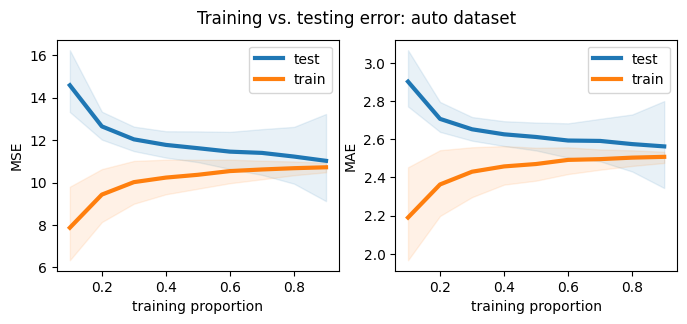

In [ ]:
fig, (a0, a1) = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
fig.suptitle("Training vs. testing error: auto dataset")

test_quantiles = np.quantile(test_mse, [0.25, 0.5, 0.75], axis=0)
train_quantiles = np.quantile(train_mse, [0.25, 0.5, 0.75], axis=0)
a0.plot(train_sizes, test_quantiles[1], label="test", lw=3)
a0.fill_between(
    train_sizes, test_quantiles[0], test_quantiles[2], color="C0", alpha=0.1
)
a0.plot(train_sizes, train_quantiles[1], label="train", lw=3)
a0.fill_between(
    train_sizes, train_quantiles[0], train_quantiles[2], lw=1, color="C1", alpha=0.1
)

a0.set_ylabel("MSE")
a0.set_xlabel("training proportion")
a0.legend()

test_quantiles = np.quantile(test_mae, [0.25, 0.5, 0.75], axis=0)
train_quantiles = np.quantile(train_mae, [0.25, 0.5, 0.75], axis=0)

a1.plot(train_sizes, test_quantiles[1], label="test", lw=3)
a1.fill_between(
    train_sizes, test_quantiles[0], test_quantiles[2], color="C0", alpha=0.1
)
a1.plot(train_sizes, train_quantiles[1], label="train", lw=3)
a1.fill_between(
    train_sizes, train_quantiles[0], train_quantiles[2], lw=1, color="C1", alpha=0.1
)

a1.set_ylabel("MAE")
a1.set_xlabel("training proportion")
a1.legend()

plt.show()

- The downward bias (optimism) in estimating predictive error with training error shrinks as the training proportion grows.

- The variance of the test set error grows as the training proportion grows.


### More data leakage?

- You can't use training data to evaluate your model. Textbook data leakage.

- Can you use testing data used to inform modeling choices, to evaluate your model? Consider:

    - You want to choose the optimal value of `n_neighbors` for your `KNeighborsRegressor` model.

    - You split off 20% of your data, giving yourself a **test set** for assessing predictive performance of models fit on the remaing 80%, your **training set**.

    - For each value of `n_neighbors` in your candidate set, you fit a `KNeighborsRegressor` model to the training set. The optimal value of `n_neighbors` is the one with the best predictive performance on the test set.

    - *Is the predictive performance of the optimal model you just identified representative of expected predictive performance on new data?*

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error


def make_data(n=100, random_state=None):
    rng = np.random.default_rng(random_state)
    x = rng.uniform(size=n)
    y = 10 * x * (x - 0.2) * (x - 0.9) + 10 * x * 0.02 * rng.normal(size=n)
    return x, y


x_test, y_test = make_data(10_000)
X_test = x_test.reshape(-1, 1)

K = np.array([1, 4, 7, 10, 13])
n_repeats = 5000
mse_val = np.zeros((n_repeats, len(K)))
mse_test = np.zeros(n_repeats)
for i in range(n_repeats):
    x_train, y_train = make_data(80)
    X_train = x_train.reshape(-1, 1)
    x_val, y_val = make_data(20)
    X_val = x_val.reshape(-1, 1)
    for j, k in enumerate(K):
        model = KNeighborsRegressor(n_neighbors=k)
        model.fit(X_train, y_train)
        mse_val[i, j] = mean_squared_error(y_val, model.predict(X_val))
    k = K[mse_val[i].argmin()]
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train, y_train)
    mse_test[i] = mean_squared_error(y_test, model.predict(X_test))

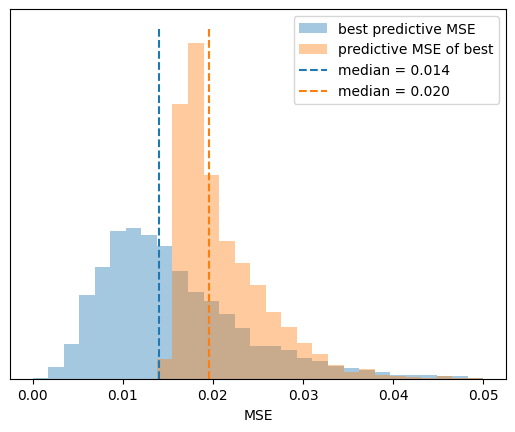

In [ ]:
bins = np.linspace(0, 0.05, 30)
plt.hist(mse_val.min(axis=1), alpha=0.4, bins=bins, label="best predictive MSE")
plt.hist(mse_test, alpha=0.4, bins=bins, label="predictive MSE of best")
ylim = plt.ylim()

val_min_median = np.median(mse_val.min(axis=1))

test_median = np.median(mse_test)

plt.plot(
    [val_min_median, val_min_median],
    ylim,
    "--C0",
    label=f"median = {val_min_median:.3f}",
)
plt.plot([test_median, test_median], ylim, "--C1", label=f"median = {test_median:.3f}")

plt.yticks([])
plt.xlabel("MSE")

plt.legend()
plt.show()

### Train/validation/test splits

- Split your data into three subsets &mdash; all large (🤨):

  - a **training set** used to fit your models;

  - a **validation set** used to evaluate modeling choices;

  - a **test set** used to assess predictive performance of your "final" model.

- After making all of your modeling choices, it's standard practice (because more data is better) to fit your final model on both the training and validation data. Assess it's predictive performance using the test set.

- For expository ergonomics, I may not bother with test sets and final assessment of predictive performance when my focus is on model building. I am not minimizing their importance!

- Many validation sets are better than one! Evaluate modeling choices using averages of many estimates of predictive error computed using many train/validation splits. Cross-validation is an efficient way to do this.

### Implicit test sets



### **$k$-fold Cross Validation (CV)**

![](assets/cross_validation.png)

(Figure cropped from [the scikit-learn cross-validation docs](https://scikit-learn.org/stable/modules/cross_validation.html).)


### Model selection using cross-validation

- Hyperparameter tuning (knob twiddling), synthetic data example

- Feature engineering

  - Feature selection, `auto` data

  - Feature scaling, `auto` data

  - Feature generation
    
    - Polynomial features, `auto` data

    - Vectorization/embedding `20newsgroups` data

    - Dimension reduction

    - Time-series features

#### Hyperparameter tuning

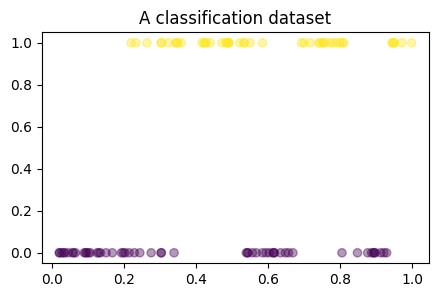

In [1]:
import numpy as np
from matplotlib import pyplot as plt

rng = np.random.default_rng()


def g(x):
    return np.sin(2.5 * np.pi * x**2) ** 2


def make_data(n):
    x = rng.uniform(size=n)
    y = rng.uniform(size=n) < g(x)
    return x, y


x, y = make_data(100)
X = x.reshape(-1, 1)
plt.figure(figsize=(5, 3))
plt.scatter(x, y, c=y, alpha=0.4)
plt.title("A classification dataset")
plt.show()

#### Feature selection

In [ ]:
df = pd.read_csv("data/auto_preprocessed.csv")
X = df.copy()
y = X.pop("mpg")

numerical_feature_lists = [
    ["weight"],
    ["weight", "year"],
    ["acceleration", "weight", "year"],
    ["cylinders", "displacement", "weight", "year"],
    ["acceleration", "cylinders", "horsepower", "weight", "year"],
    ["acceleration", "cylinders", "displacement", "horsepower", "weight", "year"],
]

#### Feature generation

##### Exercise:

- What degree polynomial best fits the data?

  - Assessing using repeated $k$-fold cross-validation. How sensitive is the optimal polynomial degree to `n_splits` and `n_repeats`?

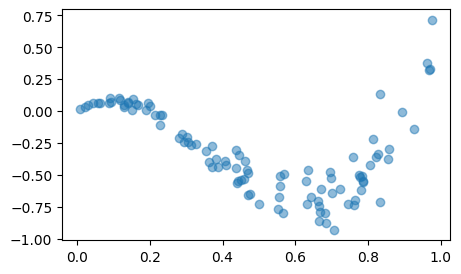

In [7]:
def make_data(n=100, random_state=None):
    rng = np.random.default_rng(random_state)
    x = rng.uniform(size=n)
    y = 10 * x * (x - 0.2) * (x - 0.9) + 10 * x * 0.02 * rng.normal(size=n)
    return x, y


x, y = make_data(random_state=42)
plt.figure(figsize=(5, 3))
plt.scatter(x, y, alpha=0.5)

#### Vectorization and embedding

### $k$-fold CV-splitting is better than $k$ random splits

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, RepeatedKFold

n_splits = 5
n_repeats = 200

random_split_mse = np.zeros(n_splits * n_repeats)

model = LinearRegression()

for i in range(n_splits * n_repeats):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    model.fit(X_train, y_train)
    random_split_mse[i] = mean_squared_error(y_test, model.predict(X_test))

cv_mse = np.zeros(n_splits * n_repeats)

rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats).split(X)
for i, (train, test) in enumerate(rkf):
    model.fit(X.loc[train], y.loc[train])
    cv_mse[i] = mean_squared_error(y.loc[test], model.predict(X.loc[test]))

random_split_mse.reshape(-1, 5).mean(axis=1).std(), cv_mse.reshape(-1, 5).mean(
    axis=1
).std()

In [77]:
from sklearn.metrics import pairwise_distances


def gaussian_weights(X, Y, bandwidth=1.0):
    def g(x):
        return np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)

    r = pairwise_distances(X_train, X_test).T
    return g(r / bandwidth)


class GaussianSmoother:
    def __init__(self, bandwidth=1.0):
        self.bandwidth = bandwidth

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        X_train = self.X_train
        y_train = self.y_train
        bandwidth = self.bandwidth
        W = gaussian_weights(X_train, X_test, bandwidth=bandwidth)
        y_pred = W @ y_train / W.sum(axis=1)
        return y_pred

In [90]:
def make_data(n=100, random_state=None):
    rng = np.random.default_rng(random_state)
    x = rng.uniform(size=n)
    y = 10 * x * (x - 0.2) * (x - 0.9) + 10 * x * 0.02 * rng.normal(size=n)
    return x, y


x_train, y_train = make_data()
X_train = x_train.reshape(-1, 1)
u = np.linspace(0, 1, 100)

smoother = GaussianSmoother(bandwidth=0.07)
smoother.fit(X_train, y_train)
v = smoother.predict(u.reshape(-1, 1))

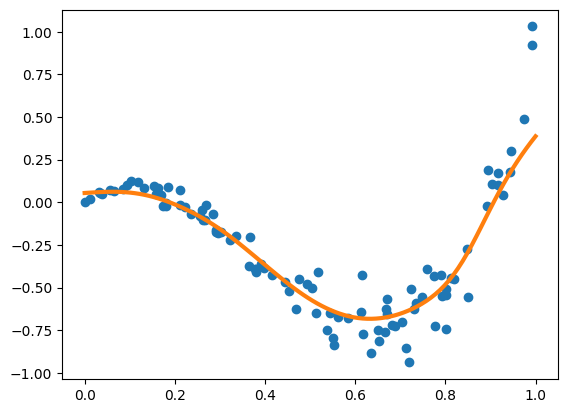

In [91]:
plt.scatter(x_train, y_train)
plt.plot(u, v, lw=3, color="C1")

In [169]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from collections import Counter
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

In [170]:
data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [171]:
print(data.data[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [ ]:
print(data.target[0])  # rec.autos

7


In [173]:
count = Counter(data.target)
count

Counter({np.int64(10): 600,
         np.int64(15): 599,
         np.int64(8): 598,
         np.int64(9): 597,
         np.int64(11): 595,
         np.int64(7): 594,
         np.int64(13): 594,
         np.int64(14): 593,
         np.int64(5): 593,
         np.int64(2): 591,
         np.int64(12): 591,
         np.int64(3): 590,
         np.int64(6): 585,
         np.int64(1): 584,
         np.int64(4): 578,
         np.int64(17): 564,
         np.int64(16): 546,
         np.int64(0): 480,
         np.int64(18): 465,
         np.int64(19): 377})

In [ ]:
vocabulary = set()
for x in data.data:
    vocabulary.update(x.split())
len(vocabulary)

280308

In [ ]:
word_list = []
for x in data.data:
    word_list.extend(x.split())
word_counts = Counter(word_list)
word_counts

Counter({'the': 127670,
         'to': 69836,
         'of': 66705,
         'a': 56148,
         'and': 52580,
         'is': 39554,
         'in': 37787,
         'I': 37616,
         'that': 34582,
         '>': 27843,
         'for': 25707,
         'you': 19874,
         'it': 19698,
         'be': 18364,
         'on': 18201,
         'have': 17292,
         'are': 17260,
         'with': 16179,
         'not': 15434,
         'The': 14079,
         'this': 13611,
         'as': 13373,
         'or': 12497,
         'was': 12426,
         'Subject:': 11642,
         'From:': 11536,
         'Lines:': 11328,
         'Organization:': 10881,
         'by': 10279,
         'but': 10265,
         '|': 10072,
         'from': 9859,
         'at': 9807,
         '-': 9662,
         'they': 9591,
         'an': 9393,
         'will': 8584,
         'can': 8493,
         'would': 8381,
         'In': 7904,
         'if': 7792,
         'about': 7768,
         'Re:': 7747,
         'my': 

In [178]:
X = sorted([(word_counts[key], key) for key in word_counts])

In [ ]:
MIN_FREQ = 2
MAX_FREQ = 1000

word_counts = {
    key: word_counts[key]
    for key in word_counts
    if word_counts[key] >= MIN_FREQ and word_counts[key] <= MAX_FREQ
}
len(word_counts)

118198

In [ ]:
index = {w: i for i, w in enumerate(word_counts)}
X = np.zeros((len(data.data), len(word_counts)), dtype=int)

for i, x in enumerate(data.data):
    for w in x.split():
        if w in index:
            X[i, index[w]] += 1

In [188]:
X.shape

(11314, 118198)

In [191]:
X_tr = X[:8000]
X_te = X[8000:]
y_tr = data.target[:8000]
y_te = data.target[8000:]
model = MultinomialNB()
model.fit(X_tr, y_tr)

MultinomialNB()

In [194]:
yhat = model.predict(X_tr)

In [196]:
np.mean(y_tr == yhat)

np.float64(0.987125)